<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Madelon: 3-ROC-AUC & f_classif

_Authors: Blake Cannon (DEN)_

---
MADELON is an artificial dataset, which was part of the NIPS 2003 feature selection challenge. This is a two-class classification problem with continuous input variables. The difficulty is that the problem is multivariate and highly non-linear. Among 500 attributes, only 20 are informative, the rest are noise.

### Notebook 2

This is the third in a series of Jupyter Notebooks and uses ROC-AUC and `f_classif` to try and solve the Madelon problem.

## Import packages

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

## Load Pickles

In [2]:
# Loading the data saved from the last notebook
X_train = np.load('./_data/X_train.npy')
y_train = np.load('./_data/y_train.npy')
X_val = np.load('./_data/X_val.npy')
y_val = np.load('./_data/y_val.npy')
X_test = np.load('./_data/X_test.npy')

## Area Under the Curve (AUC)

We'll use `roc_auc_score` from `sklearn.metrics` to measure the rate of positives vs negatives as the first benchmark.

A completly random selection would be a baseline of 0.5.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [4]:
# Instatiate and fit the logistic regression model
logr = LogisticRegression()
logr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
print(logr.predict_proba(X_train).shape)
logr.predict_proba(X_train)

(2000, 2)


array([[ 0.36103151,  0.63896849],
       [ 0.46582704,  0.53417296],
       [ 0.70241725,  0.29758275],
       ..., 
       [ 0.67524771,  0.32475229],
       [ 0.47564307,  0.52435693],
       [ 0.29721952,  0.70278048]])

In [6]:
# Print shape of the X_Train
print(logr.predict_proba(X_train)[:,1].shape)
logr.predict_proba(X_train)[:,1]

(2000,)


array([ 0.63896849,  0.53417296,  0.29758275, ...,  0.32475229,
        0.52435693,  0.70278048])

In [7]:
# Find the ROC/AUC on one column of the logistic regression predict_proba on the training dataset
roc_auc_score(y_train,logr.predict_proba(X_train)[:,1])

0.8244260000000001

In [8]:
# Find the AUC on one column of the logistic regression predict_proba on the validation dataset
roc_auc_score(y_val,logr.predict_proba(X_val)[:,1])

0.60188888888888881

A baseline of 0.602 is not very good considering random guessing should give us a score of 0.5. Note that the score of 0.824 on the training set is **overfit**.

The Madelon dataset has a massive amount of unimportant features. We know this because of the difference between the ROC-AUC score differences above (0.602:validation vs 0.824:train). So, we need to remove these unimportant features (feature selection) so we can create a better model.

I chose the `f_class` test because it tests differences among classes.

---

## Feature Selection Using f_classif

In order to find the optimal features in the Madelon dataset we'll run a `f_classif` test from the `sklearn` package. Other testing methods are available, but this is a classification problem and `f_class` is specifically designed for this type of problem.

>**What are F-statistics and the F-test?**

>F-tests are named after its test statistic, F, which was named in honor of Sir Ronald Fisher. The F-statistic is simply a ratio of two variances. Variances are a measure of dispersion, or how far the data are scattered from the mean. Larger values represent greater dispersion.

>F is for F-test
>Variance is the square of the standard deviation. For us humans, standard deviations are easier to understand than variances because they’re in the same units as the data rather than squared units. However, many analyses actually use variances in the calculations.

>F-statistics are based on the ratio of mean squares. The term “mean squares” may sound confusing but it is simply an estimate of population variance that accounts for the degrees of freedom (DF) used to calculate that estimate.

>Despite being a ratio of variances, you can use F-tests in a wide variety of situations. Unsurprisingly, the F-test can assess the equality of variances. However, by changing the variances that are included in the ratio, the F-test becomes a very flexible test. For example, you can use F-statistics and F-tests to test the overall significance for a regression model, to compare the fits of different models, to test specific regression terms, and to test the equality of means.

>To use the F-test to determine whether group means are equal, it’s just a matter of including the correct variances in the ratio. In one-way ANOVA, the F-statistic is this ratio:

>**F = variation between sample means / variation within the samples**

>-The Minitab Blog [1]

[1]: http://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test

The test will return a p-value. As with p-values, a small p-value (p < 0.05) would indicate whether or not a feature is relative or irrelative.

We'll combine `sklearn`'s `f_classif` and `SelectPercentile` to compute the ANOVA f-value, p-values, and choose a certain percentage of relevant features. 

In [9]:
from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.preprocessing import PolynomialFeatures

In [10]:
# Set up feature selection by selecting most relative 50 percent of features
select_feature = SelectPercentile(f_classif, percentile=50)
# Fit the feature selection model
select_feature.fit(X_train,y_train)

SelectPercentile(percentile=50,
         score_func=<function f_classif at 0x10fcbcc80>)

Since this is a **classification** problem. we'll use the `SelectPercentile` function to select a percentage of features that score high.

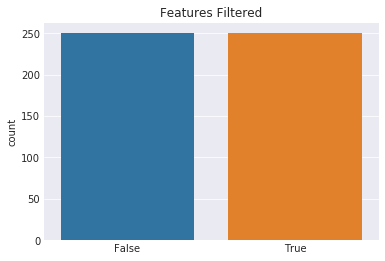

In [11]:
# Now we'll make an array of booleans for those upper 50 percent of features
feature_filter = select_feature.get_support()

# Plot the filter results
sns.countplot(feature_filter)
plt.title('Features Filtered')
plt.savefig('./_assets/3-1-feature-filter')
plt.show()

f_classif p-values mean: 0.471989720132


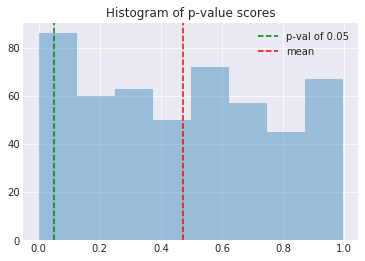

In [12]:
# Here is the mean and array of f_classif p-values of the features
print('f_classif p-values mean:', select_feature.pvalues_.mean())

# Plot histogram of p-value scores
sns.distplot(select_feature.pvalues_, kde=False)
plt.axvline(.05, linestyle='dashed', label='p-val of 0.05', color='g')
plt.axvline(select_feature.pvalues_.mean(), label='mean', linestyle='dashed', color='r')
plt.title('Histogram of p-value scores')
plt.legend()
plt.savefig('./_assets/3-2-hist-pvals')
plt.show()

f_classif scores mean: 2.10801794996


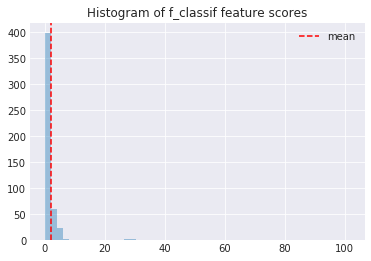

In [13]:
# Here is the mean and array of f_classif scores of the features
print('f_classif scores mean:', select_feature.scores_.mean())

# Plot histogram of f_classif scores
sns.distplot(select_feature.scores_, kde=False)
plt.axvline(select_feature.scores_.mean(), label='mean', linestyle='dashed', color='r')
plt.title('Histogram of f_classif feature scores')
plt.legend()
plt.savefig('./_assets/3-3-hist-f_classif-scores')
plt.show()

The of the `select_feature.scores_` is 2.11 and the mean of the `select_feature.pvalues_` is 0.47. This once again shows us that there is a high amount of unimportant features. This same information can clearly be seen in the two histograms. 

The histogram of `select_feature.pvalues_` also shows how many unimportant features there are. The green dashed line on the histogram represents the typical p-value cutoff of 0.05, and the red dashed line is the mean. We can see with this high mean and distribution of p-scores greater than 0.05. A small p-value (less than 0.05) would indicate thata certain feature was useful in predicting the target

The histogram of `select_feature.scores_` indicates that most of the scores are very close to zero. There are a handful of high ranking scores but they are so low in appearance that they can't really be seen on the histogram. We really only know these high scores exist because of the extent of the x-axis.

Next, we'll create a **threshold** and use to pick which features are important.

Number of filtered features: 13
Number of un-filtered features: 487


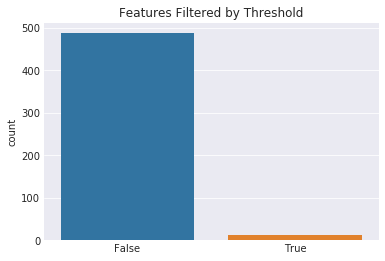

In [14]:
# Create array of booleans of features with scores greater than 10
feature_filter = select_feature.scores_ > 10

# Print sum of 'True' in feature_filter
print('Number of filtered features:', np.sum(feature_filter))
print('Number of un-filtered features:', len(feature_filter) - np.sum(feature_filter))

# Plot the filter results
sns.countplot(feature_filter)
plt.title('Features Filtered by Threshold')    
plt.savefig('./_assets/3-4-feature-filter-threshold')
plt.show()

In [15]:
# Generate a new feature matrix consisting of all polynomial combinations of
# the features with degrees less than or equal to 2
interactions = PolynomialFeatures(degree=2, interaction_only=True)
X_interactions = interactions.fit_transform(X_train[:,feature_filter])
print('No of features and their interactions:', X_interactions.shape[1])

No of features and their interactions: 92


In [16]:
# Fit_transform to see if there's any relationships in the model
logr.fit(X_interactions, y_train)
X_val_filtered = interactions.fit_transform(X_val[:,feature_filter])
# Print validation score on the filtered X
roc_auc_score(y_val, logr.predict_proba(X_val_filtered)[:,1])

0.80815555555555563

The ROC/AUC score of 0.808 is just slightly below the original *overfit* score of 0.824 on the training dataset. Thus, it seems that using `p_classif` as a feature selection could be valid because the lower score would mean it's not overfitting but also doing a good job at solving the madelon problem.

In [17]:
# np array of whether or not the feature is important
feature_filter

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [18]:
counter = -1
important_features = []
for i in feature_filter:
    counter += 1
    if i == True:
        important_features.append(counter)
print('Number of important features:', len(important_features))
print('List of important features:', important_features)

Number of important features: 13
List of important features: [48, 64, 105, 128, 241, 336, 338, 378, 442, 453, 472, 475, 493]


The feature selection method above is known as **univariate selection** which decides the best features by looking at how they work individually. Univariate selection does not look at how they would preform together in harmony. The weakness in the method above is collinearity. These methods are simple to run and understand and are in general particularly good for gaining a better understanding of data (but not necessarily for optimizing the feature set for better generalization).
    
In datasets with smaller amount of noise, the correlation is relatively strong, with a very low p-value, while in large datasets with lots of noise (like Madelon), the correlation is very small. Thus, the p-value is high meaning that it is very likely to observe such correlation is by chance.